# Un estudio sobre los retornos del mercado de renta fija dominicano

utilizando basados en modelos AR-GARCH

Trabajo final de tópicos de econometría

Ian Contreras (INSTITUTO TECNOLÓGICO DE SANTO DOMINGO (INTEC))  
October 19, 2024

Este estudio tiene como objetivo analizar los retornos y la volatilidad del mercado de deuda pública dominicana mediante la aplicación de modelos ARMA-GARCH. A través de estos modelos, se busca identificar patrones en el comportamiento de los retornos y predecir su evolución futura.

In [2]:
# Manejo de datos y análisis
import numpy as np
import pandas as pd
import scipy.stats as stats

# Modelos estadísticos y econométricos
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from arch import arch_model

In [3]:
df = pd.read_csv('data\csv\irp.csv', parse_dates=['date'], index_col='date')
returns = df['price_return']
split_date = '2020-12-31'
R_test = df[df.index >= split_date]['price_return'].rolling(
    window=5).std().dropna()

# Introducción

El mercado de renta fija en la República Dominicana ha emergido como uno de los sectores más importantes dentro de la economía, especialmente en lo que respecta a la deuda pública, la cual juega un papel crucial en la financiación de proyectos gubernamentales y el sostenimiento de la política fiscal. En los últimos cincuenta años, el país ha experimentado un crecimiento económico significativo, consolidándose como una de las economías más dinámicas de América Latina. Este crecimiento ha estado acompañado por una mayor complejidad económica, lo que ha incrementado la relevancia del mercado financiero dominicano, en particular el mercado de deuda pública, que ha sido un activo clave para fondos de pensiones y fondos de inversión.

Sin embargo, este mercado también presenta importantes desafíos, especialmente en términos de baja liquidez en el mercado secundario y episodios de alta volatilidad. Estos problemas dificultan la previsión precisa de los movimientos del mercado y complican la toma de decisiones estratégicas para los inversores. En este contexto, surge la necesidad de utilizar herramientas econométricas que puedan capturar con mayor precisión las dinámicas subyacentes de los retornos y la volatilidad del mercado de deuda pública dominicano.

La **pregunta de investigación** que guía este estudio es: ¿Es posible modelar adecuadamente los retornos y la volatilidad del mercado de deuda pública dominicano mediante modelos ARIMA-GARCH?, y ¿Qué tan efectivas son estas técnicas para predecir el comportamiento futuro del mercado, especialmente durante periodos de alta volatilidad?

El **objetivo principal** de este estudio es aplicar modelos ARMA-GARCH para analizar y predecir el comportamiento de los retornos del índice de deuda pública IRP-GOBIX, considerando tanto la tendencia como los patrones de volatilidad del mercado. A través de la estimación de estos modelos, se busca identificar los principales factores que afectan la dinámica de los retornos y proporcionar información valiosa para los actores del mercado, facilitando una gestión más eficiente del riesgo.

Además, este estudio pretende evaluar la **consistencia de los modelos** y determinar si los modelos de volatilidad más sofisticados, como el Zero-GARCH, ofrecen una mejor capacidad de predicción que los modelos tradicionales basados únicamente en niveles y diferencias, como el ARIMA. Un aspecto clave será analizar si el modelo GARCH captura adecuadamente los choques bruscos y los episodios de volatilidad extrema, o si suaviza excesivamente estos movimientos.

La **relevancia** de este estudio radica en la creciente importancia del mercado de deuda pública dominicano, tanto para la estabilidad financiera del país como para los inversores extranjeros que buscan oportunidades de inversión en mercados emergentes. Comprender los patrones de retorno y volatilidad es esencial para diseñar estrategias de inversión que minimicen el riesgo y maximicen el rendimiento en un entorno económico globalizado y altamente incierto.

# Metodología

El modelo ARIMA(p,d,q), donde AR(p) es el componente autorregresivo de orden p, d denota el orden de la diferencia aplicada para transformar una serie temporal no estacionaria en estacionaria, y MA(q) representa el promedio móvil de orden q. La esencia del modelo ARIMA radica en la combinación de la operación de diferenciación y el modelo ARMA. Cualquier serie no estacionaria puede volverse estacionaria mediante una diferenciación de orden adecuado, permitiendo así ajustar un modelo ARMA a la serie transformada.

El modelo de promedio móvil autorregresivo ARMA(p,q) incluye tanto un componente autorregresivo de orden p como uno de promedio móvil de orden q, y se estructura de la siguiente forma:

$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
$$ {eq: arma}

Estos modelos son adecuados solo para describir series temporales suaves, mientras que en la práctica, a menudo se trabaja con series temporales no suaves. Para estos casos, aplicar una o dos diferenciaciones puede transformar los datos en series suaves.

Si no se cumple el supuesto de homogeneidad de la varianza, puede ocurrir heterocedasticidad. Dado que los datos de la muestra son suaves, en este documento se establece un modelo ARMA(p,q) para la serie de rendimientos con el fin de describir las características de volatilidad del índice GOBIX. Se realizan pruebas de efecto ARCH y se resuelve el problema de la heterocedasticidad mediante un modelo GARCH.

El modelo GARCH extiende el modelo ARCH al considerar la autocorrelación de orden p en la función de heterocedasticidad, lo que permite ajustar de manera efectiva una función de heterocedasticidad con memoria a largo plazo. El modelo GARCH se define de la siguiente manera:

$$
a_t = \sigma_t \epsilon_t, \quad \sigma_t^2 = \alpha_0 + \sum_{i=1}^{p} \alpha_i a_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2
$$ {#eq: garch}

El modelo GARCH, propuesto por Bollerslev, atribuye la volatilidad actual tanto a la volatilidad de momentos pasados como a los errores de momentos pasados, lo que le permite explicar el fenómeno de agrupación en la volatilidad de los rendimientos financieros.

# Datos

## Fuente de datos

Un Índice Financiero es una medida estadística que refleja el valor de un conjunto de activos financieros agrupados de acuerdo con ciertos criterios.Estos se utilizan como objetivo de rendimiento de portafolios, referencias sobre las características retorno/riesgo de una clase de activo y como referencia para productos anclados a índices.

En el mercado de renta fija de la República Dominicana, el único índice público es el GOBIX, que representa la deuda gubernamental consolidada en peso. Este índice está compuesto por títulos emitidos localmente por el Banco Central y el Ministerio de Hacienda, y se publica en dos modalidades: índice de precio limpio e índice de retorno-precio. Para este estudio, se utilizará el índice de retorno precio @sec-retorno-precio, ya que aisla el componente de retorno de mercado el cual es el objetivo de estudio.

El GOBIX se caracteriza por los siguientes criterios:

-   **Elegibilidad**: Solo se incluyen títulos “bullet” emitidos en pesos dominicanos con al menos 60 días desde su emisión.
-   **Liquidez**: Los títulos se seleccionan en función del Índice de Bursatilidad publicado por la Proveedora de Precios, garantizando la inclusión de los instrumentos más negociados.
-   **Ponderación**: La ponderación se realiza por capitalización de mercado, lo que asegura que los títulos más relevantes tengan mayor peso en el índice.
-   **Rebalanceo**: Se efectúa un rebalanceo mensual para ajustar el índice según la disponibilidad de inversión en los bonos.
-   **Fuentes de información**: Los datos provienen de la Bolsa de Valores de la República Dominicana y la Proveedora de Precios.

## Índice de Retorno-Precio

El índice de retorno-precio es una metodología utilizada para calcular el rendimiento de un índice de renta fija, centrándose exclusivamente en las variaciones del precio limpio de los títulos, sin tener en cuenta los intereses acumulados ni el pago de cupones durante el período de cálculo. En el contexto del GOBIX, este índice refleja las fluctuaciones en los precios de los bonos dominicanos debido a las variaciones en las tasas de interés del mercado.

**Características del Índice de Retorno-Precio del GOBIX**:

-   **Enfoque en el Precio Limpio**: El cálculo del índice se basa en el precio limpio de los bonos, excluyendo los intereses acumulados.

-   **Reflejo de la Volatilidad**: Este índice es un indicador del riesgo asociado a las fluctuaciones en las tasas de interés y su impacto en el capital invertido.

-   **Fórmula de Cálculo**:

    $$
    IRP_t = IRP_{m-1} \times (1 + RPI_t)
    $$

    Donde:

    -   $IRP_0 = 100$ es el valor base del índice en la fecha de inicio.
    -   $IRP_t$ es el valor del índice en el día $t$.
    -   $IRP_{m-1}$ es el valor del índice en el último día hábil del mes anterior.
    -   $RPI_t$ es el retorno-precio del índice en $t$.

El retorno-precio del índice ($RPI_t$) se calcula como la suma ponderada del retorno-precio de cada bono ($RPI_{i,t}$), donde la ponderación ($\omega_i$) se determina según la capitalización de mercado de cada bono.

En este análisis, expresaremos la serie de retornos en puntos básicos para evitar problemas de escalamiento de los datos y posibles desbordamientos decimales (overflow decimal), que pueden ocurrir cuando se manejan fluctuaciones muy pequeñas con alta precisión. Un punto básico equivale a 0.01% o 1/100 de un porcentaje. Este enfoque nos permitirá manejar los datos con mayor estabilidad y evitar posibles errores numéricos derivados del escalamiento inapropiado. No tiene efectos estadísticos en las distribución.

## Selección de muestra de entrenamiento/prueba

Durante la pandemia, se experimentó uno de los ciclos de tasas de interés más pronunciados de las últimas décadas. Este periodo presentó características estructurales distintas en comparación con los ciclos históricos previos. Para evitar sesgos en las estimaciones debido a la alta volatilidad observada durante ese tiempo, evaluaremos únicamente la serie de retornos entre el periodo 2014-2021, que se considera un ciclo de tasas más regular.

La metodología empleada para dividir el conjunto de datos en muestras de entrenamiento y prueba será el **Time Series Cross-Validator**. A diferencia de la validación cruzada tradicional, que aleatoriza los datos, esta técnica respeta el orden temporal, lo cual es crucial en el análisis de series de tiempo.

En cada partición (k-ésimo split), la técnica funciona de la siguiente manera:

-   **Conjunto de Entrenamiento**: Incluye los primeros *k* pliegues (folds).
-   **Conjunto de Prueba**: Incluye el pliegue *(k+1)*.

# Análisis Exploratorio

El objetivo de este análisis exploratorio es examinar la serie de retornos diarios del IRP-GOBIX para identificar patrones de volatilidad, evaluar la distribución de los retornos, y explorar la autocorrelación en los datos. Utilizando herramientas estadísticas como la distribución de los retornos, el test de estacionariedad Dickey-Fuller, y los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF), se busca comprender la dinámica temporal de los retornos y validar la aplicación de modelos ARMA-GARCH para capturar su comportamiento futuro. Adicionalmente, se ajustarán diversas distribuciones teóricas, como la distribución normal y la t de Student, para evaluar su capacidad de describir las características empíricas de los datos.

## Histórico de retornos precio del mercado de deuda pública dominicano

``` python
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(df.index, df['price_return'])
ax.set_ylabel('Retorno Precio (BPS)')
ax.set_xlim([df.index.min(), df.index.max()])
ax.legend()
plt.show()
```

    No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

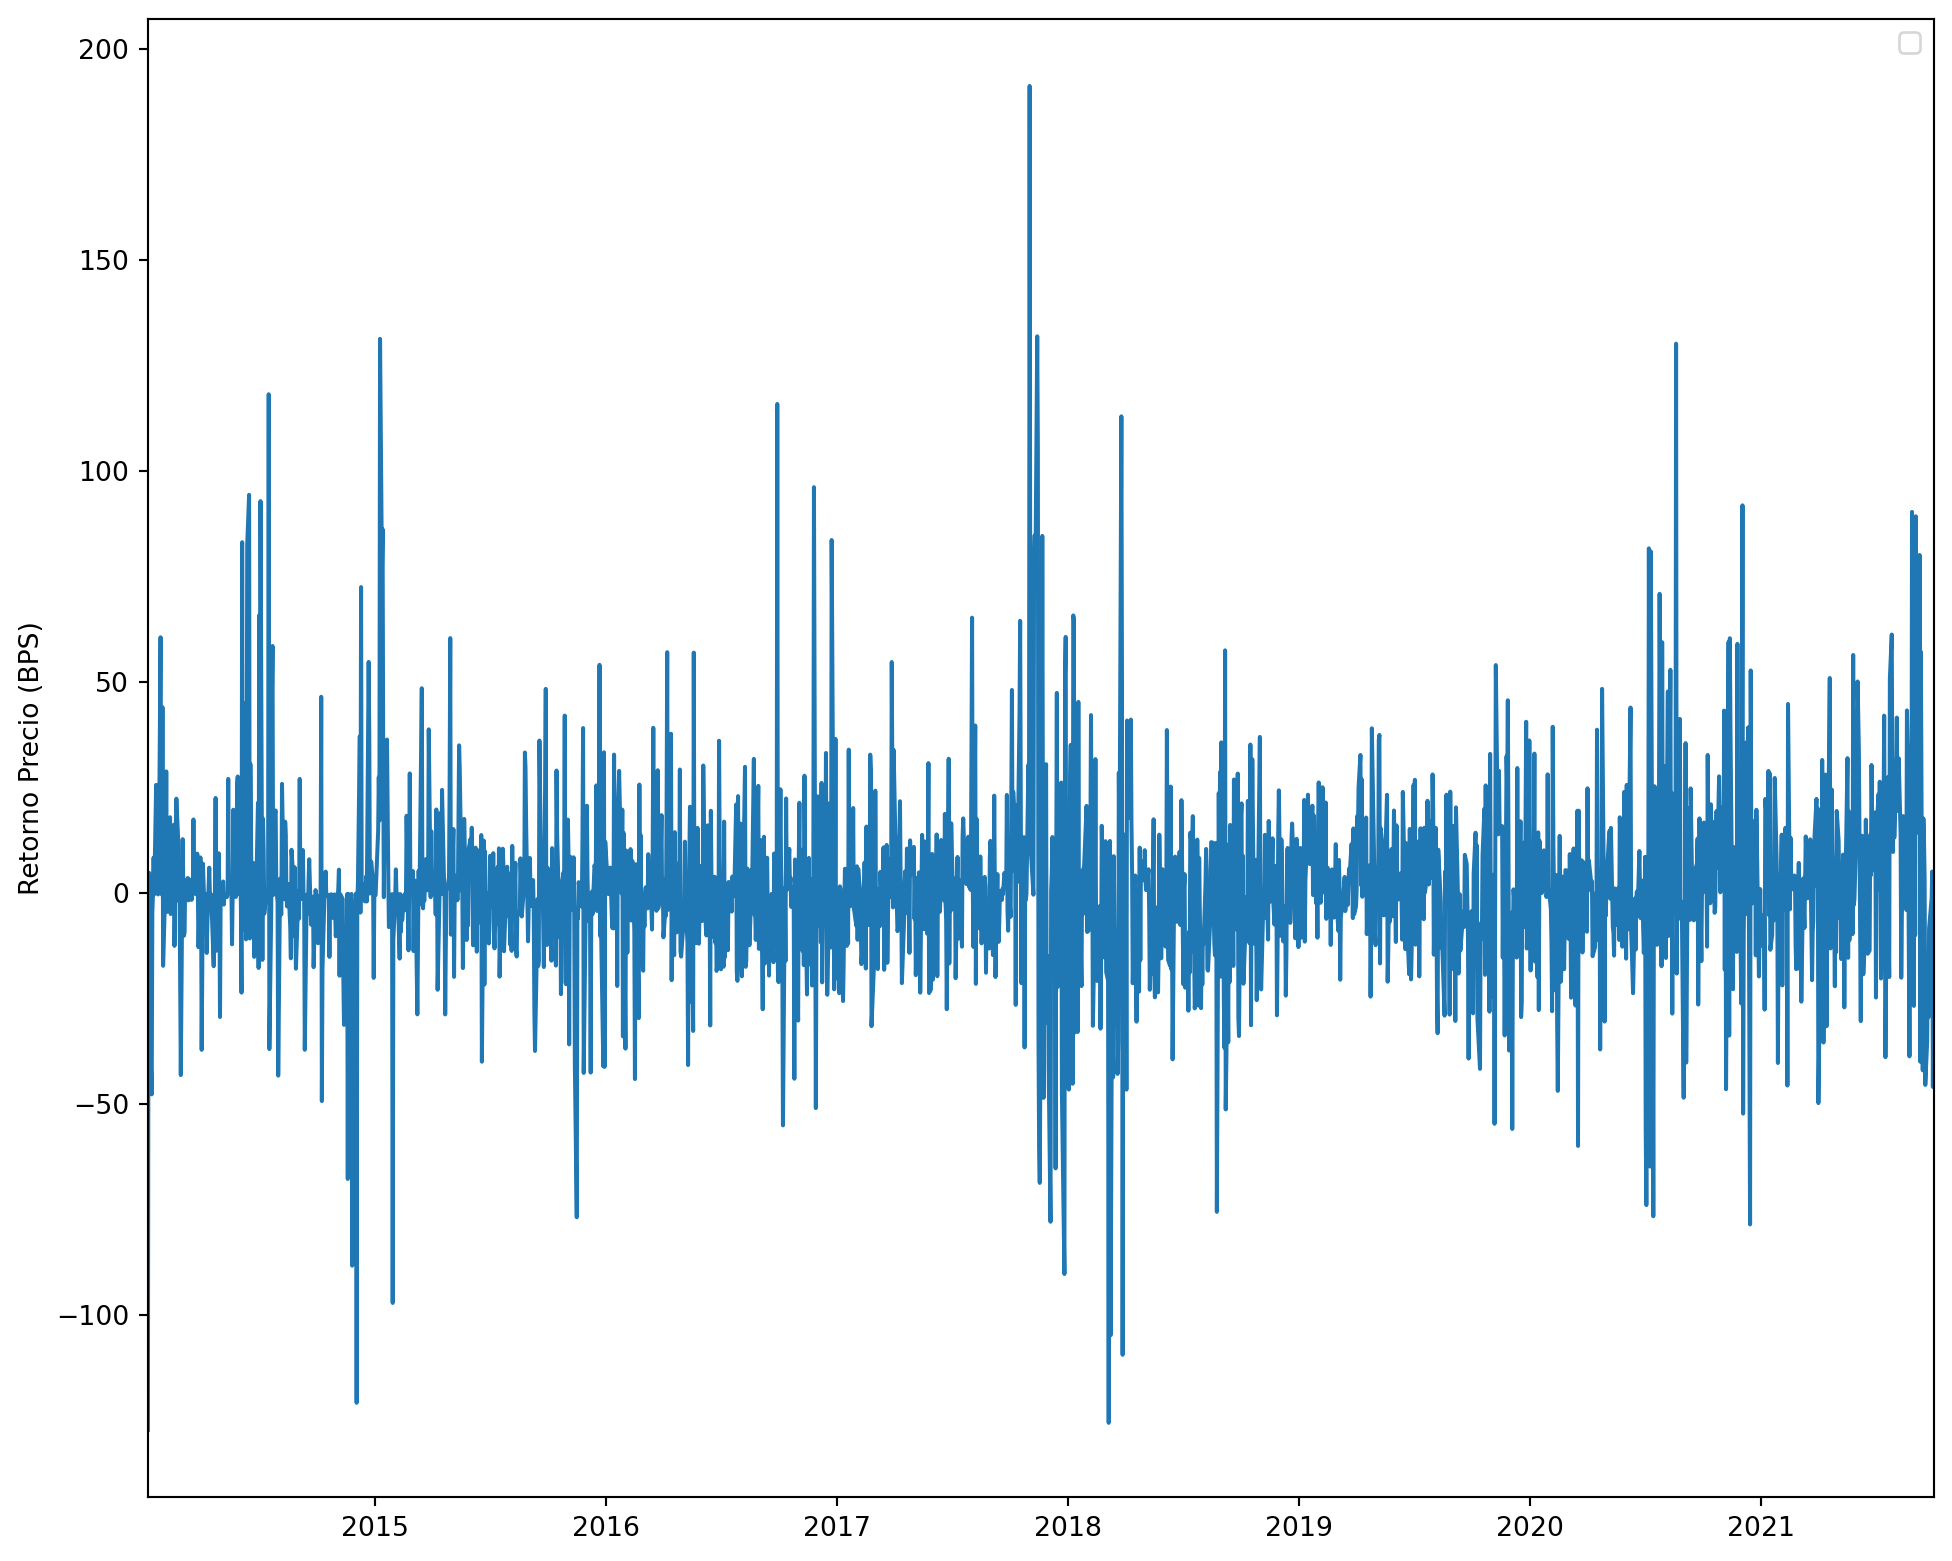

El análisis de la serie de retornos diarios del IRP-GOBIX revela un comportamiento interesante, con periodos prolongados de baja volatilidad seguidos por episodios de alta volatilidad. Entre 2015 y 2022, los retornos se mantuvieron generalmente dentro de un rango de ±50 puntos básicos, lo que indica una estabilidad relativa. Sin embargo, en momentos clave, como el ciclo de tasas de 2018, la volatilidad se incrementó drásticamente, alcanzando picos de hasta 200 puntos básicos. Este patrón es característico del fenómeno conocido como **“volatility clustering”**, donde periodos tranquilos son seguidos por fases de mayor volatilidad. La naturaleza de estos picos parece estar relacionada con factores externos, como cambios en las tasas de interés y la incertidumbre macroeconómica global, lo que subraya la importancia de emplear modelos ARMA-GARCH para capturar estas dinámicas y prever comportamientos futuros en el mercado de deuda pública dominicana.

## Análisis descriptivo de la muestra

In [4]:
desc_stats = returns.describe()

skewness = returns.skew()
kurtosis = returns.kurtosis()
jb_test = sm.stats.jarque_bera(returns)

descriptive_table = pd.DataFrame({
    'Observations': [int(desc_stats['count'])],
    'Mean': [desc_stats['mean']],
    'Median': [desc_stats['50%']],
    'Std. Dev': [desc_stats['std']],
    'Skewness': [skewness],
    'Kurtosis': [kurtosis],
    'Jarque-Bera': [jb_test[0]],
    'Prob.': [jb_test[1]]
})
descriptive_table

El análisis descriptivo de los retornos ofrece una perspectiva más detallada sobre la distribución de la serie. Con un total de 1,941 observaciones, la **media** de los retornos es de $1.353251$, lo que indica un rendimiento promedio positivo. Sin embargo, la **mediana** de $-0.318044$ sugiere un leve sesgo hacia valores negativos, lo que refleja que la mayoría de los retornos tienden a ser ligeramente inferiores a la media. La **desviación estándar**, con un valor de $23.502911$, revela una amplia dispersión de los datos, lo que confirma la presencia de una volatilidad significativa en los rendimientos, muy superior al valor medio.

En cuanto a la **asimetría** ($0.70527$), se observa una ligera inclinación hacia valores extremos positivos, lo que implica la existencia de eventos fuera de lo común que afectan los rendimientos. La **kurtosis** de $7.587995$ indica una distribución **leptocúrtica**, caracterizada por una alta concentración de valores alrededor de la media y colas más gruesas que una distribución normal, lo que es típico en datos financieros que presentan eventos extremos. El **test de Jarque-Bera**, con un valor de $4,789.532331$, confirma que la serie no sigue una distribución normal, validando la presencia de asimetría y colas pesadas en los datos. Estos resultados resaltan la necesidad de emplear modelos que puedan capturar adecuadamente estos comportamientos no lineales, esenciales para el análisis del mercado.

## Análisis de la distribución de los retornos

``` python
distributions = [stats.norm, stats.t]

plt.figure(figsize=(10, 6))
plt.hist(returns, bins=50, density=True, alpha=0.6, label='Resultados Empíricos')

for dist in distributions:
    params = dist.fit(returns)
    x = np.linspace(returns.min(), returns.max(), 100)
    plt.plot(x, dist.pdf(x, *params), label=f'{dist.name} fit')

plt.xlabel('Retorno Precio (BPS)')
plt.ylabel('Verosimilitud')
plt.legend()
plt.show()
```

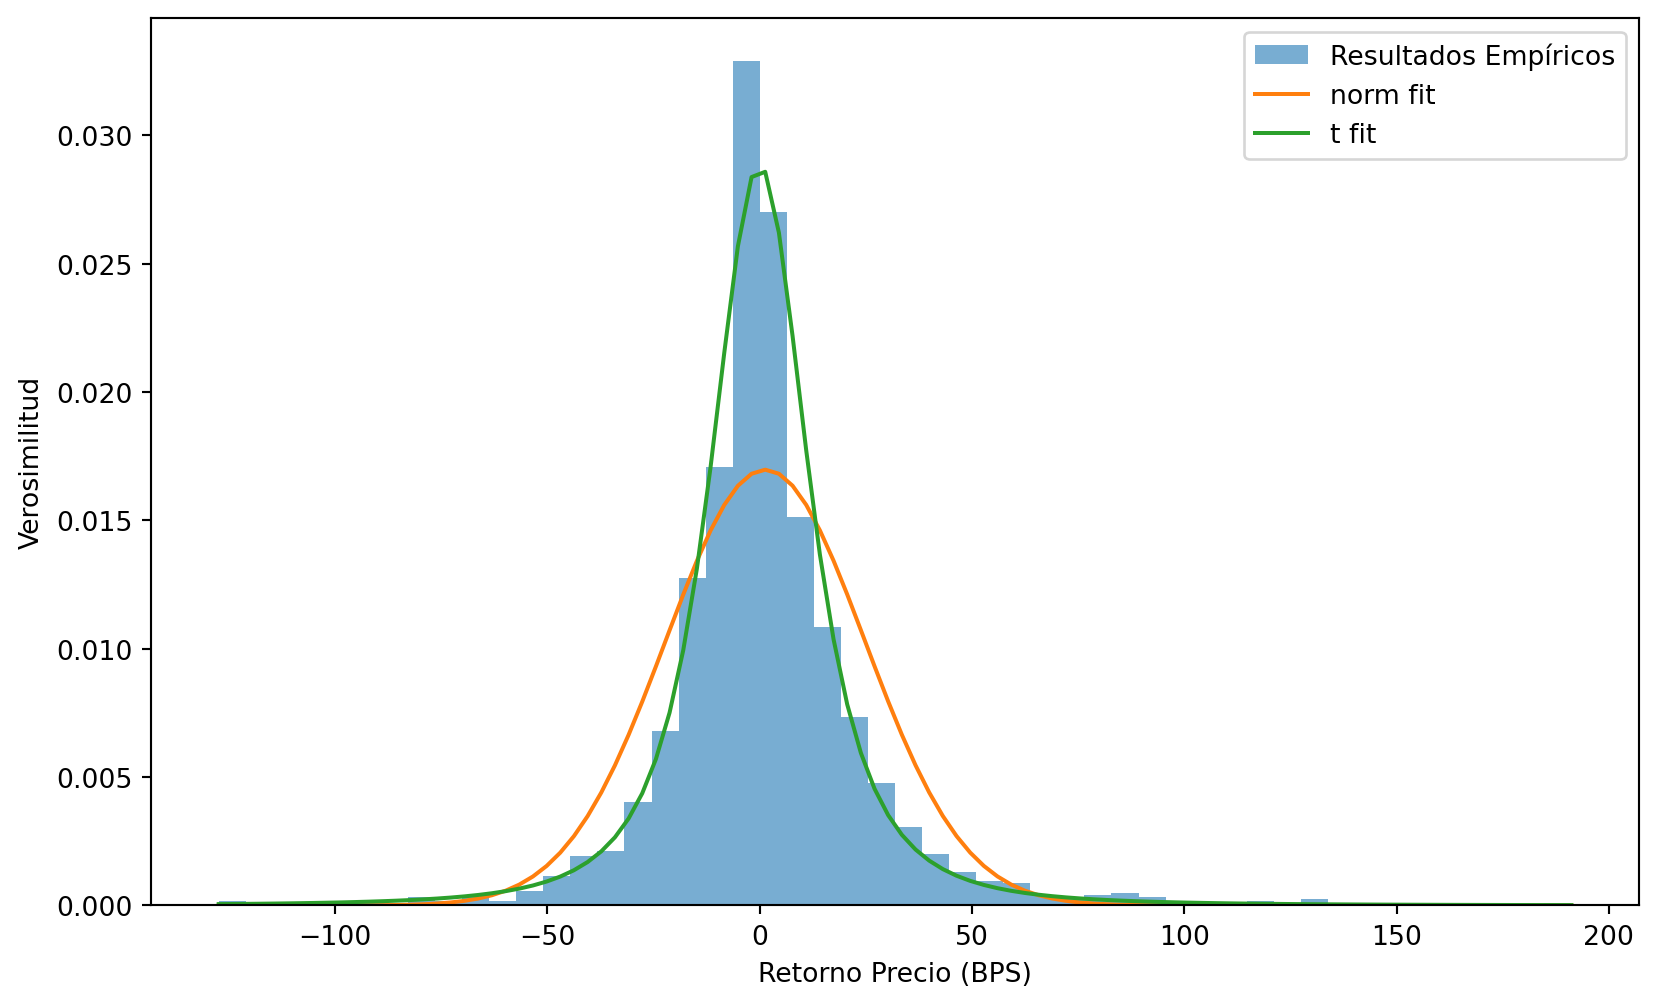

Al ajustar diferentes distribuciones a los retornos, observamos que la distribución empírica (en azul) tiene una alta concentración en torno a cero, con colas más gruesas de lo que se esperaría bajo una distribución normal. Entre las distribuciones probadas, la t de Student (en rojo) es la que mejor captura los valores extremos, con colas más largas y una mayor concentración en el centro, lo que es típico en series financieras que experimentan episodios de alta volatilidad. En contraste, la distribución normal (en naranja) y la lognormal (en verde) subestiman las colas, demostrando su ineficacia para modelar adecuadamente los valores atípicos. Esto refuerza la idea de que la t de Student es una mejor candidata para modelar los retornos, dado que puede ajustarse mejor a la leptocurtosis observada en los datos.

``` python
t_params = stats.t.fit(returns)

fig, ax = plt.subplots(figsize=(12, 10))
stats.probplot(returns, dist="t", sparams=t_params, plot=plt)
plt.grid(True)
plt.show()
```

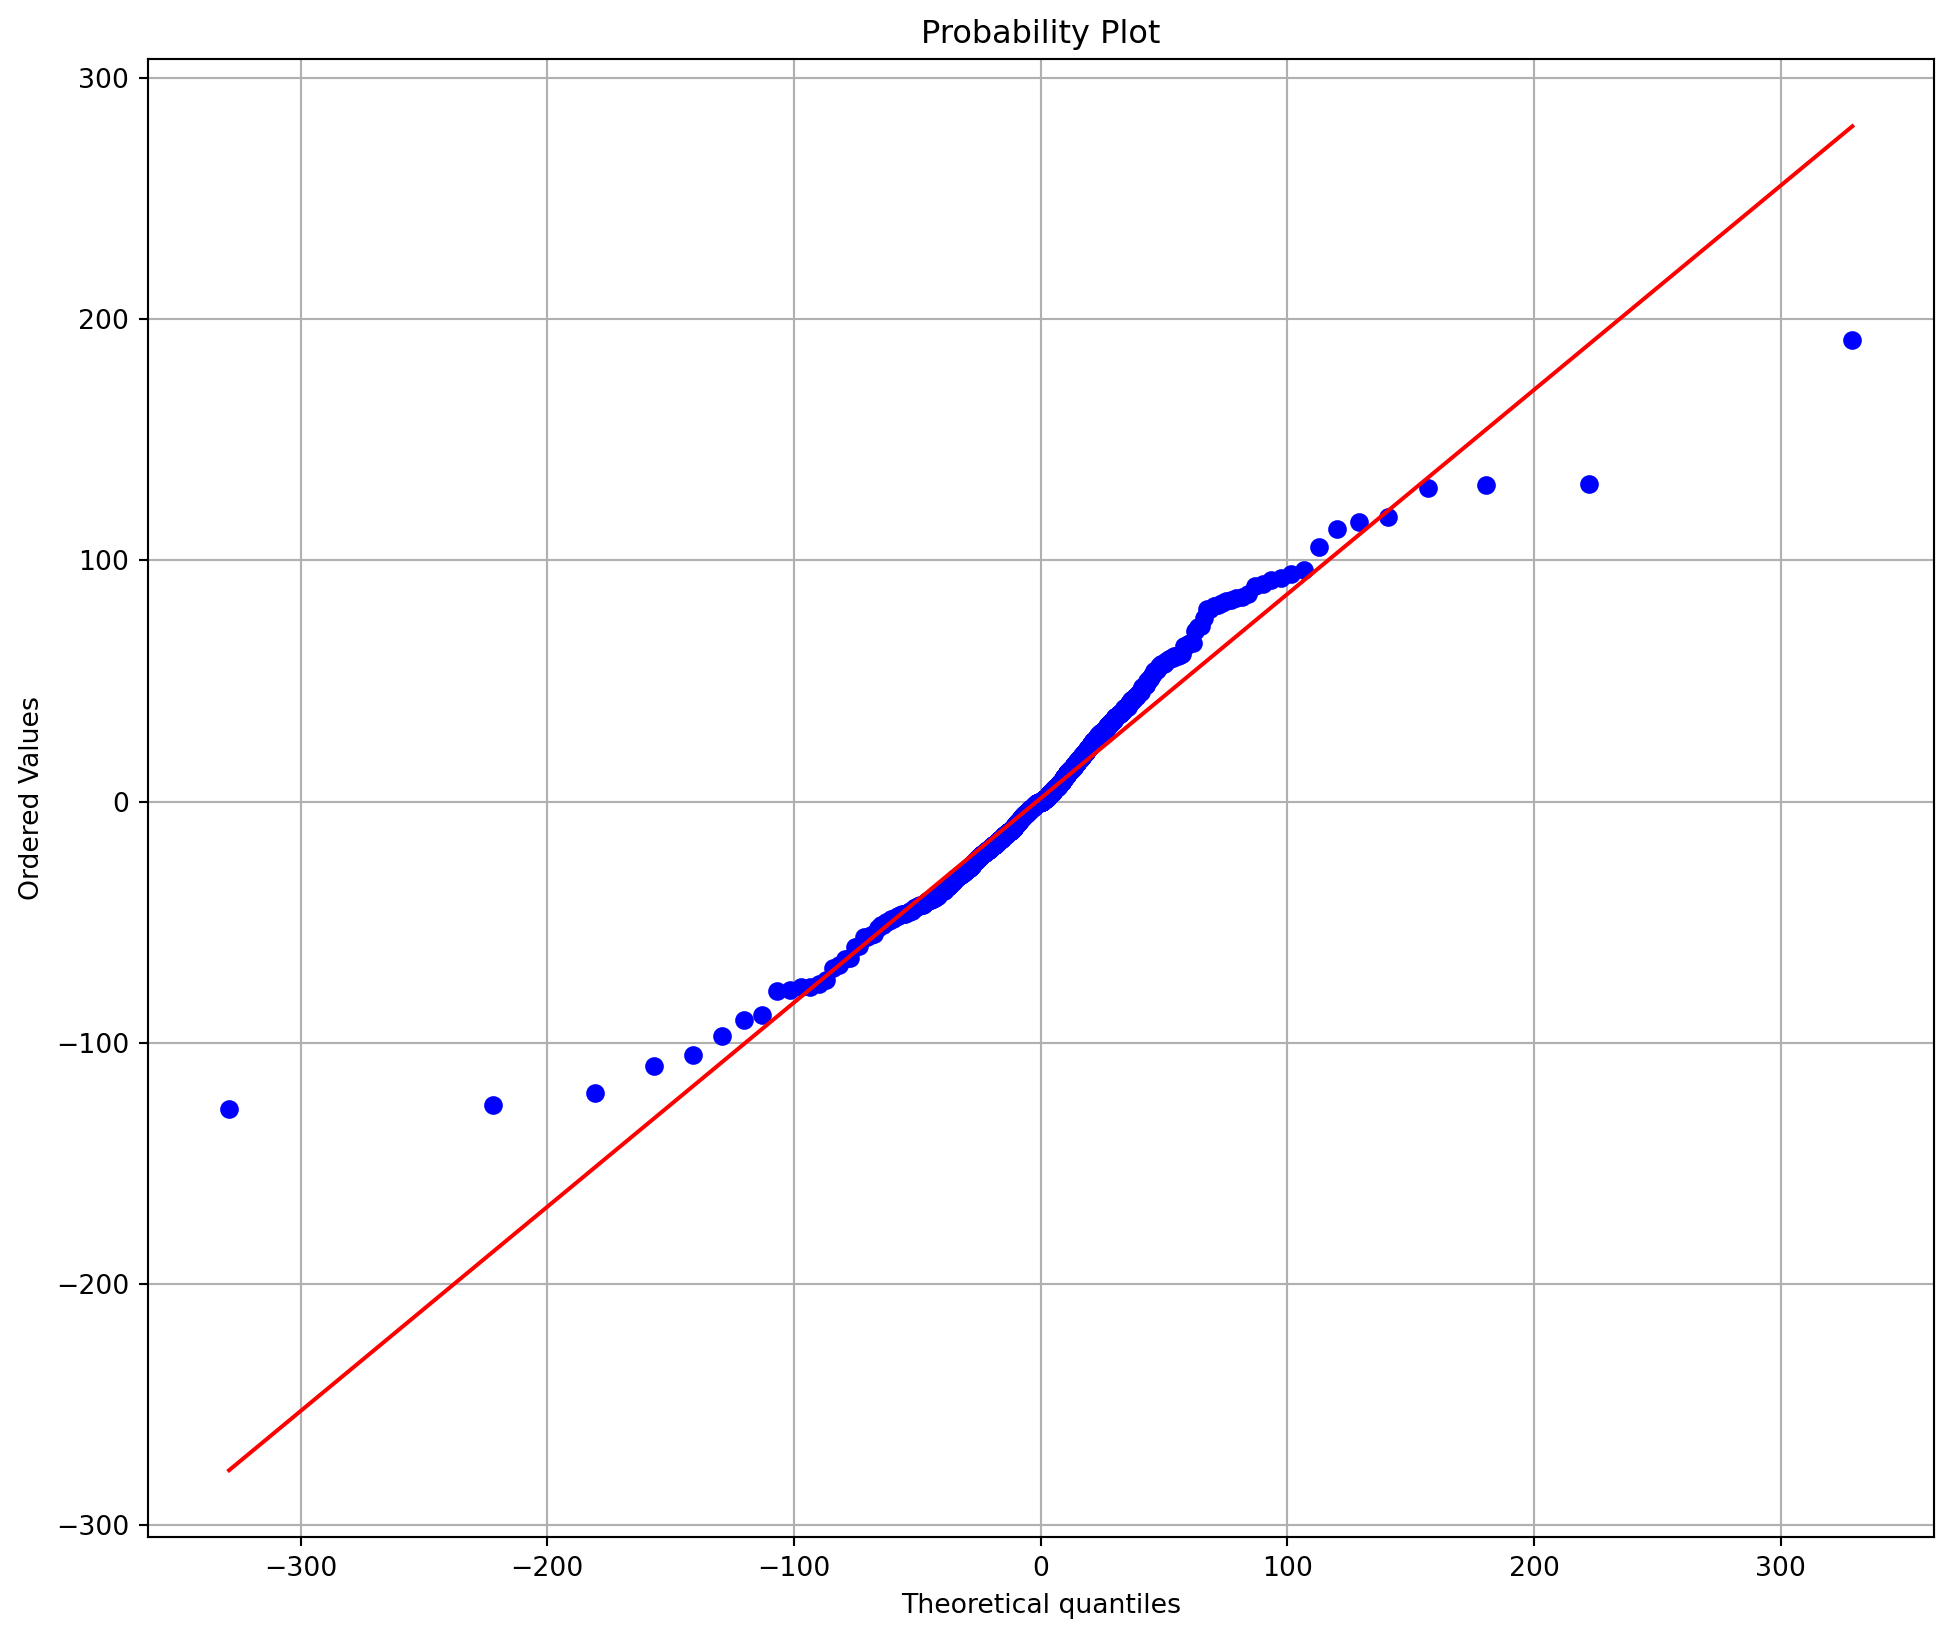

La gráfica Q-Q (Quantile-Quantile) compara los cuantiles teóricos de la distribución t de Student con los cuantiles observados de los retornos del GOBIX. En general, la mayoría de los puntos se alinean bien con la línea roja, lo que sugiere que los retornos de precios siguen razonablemente esta distribución, particularmente en las partes centrales. Sin embargo, en las colas extremas, se observan algunas desviaciones, lo que indica que, aunque la t de Student es un buen ajuste, no es perfecta para todos los escenarios.

El **estadístico de Kolmogorov-Smirnov** es de $0.0286$, con un **p-valor** de $0.0827$. Aunque esto sugiere que la t de Student captura bien la mayor parte de los retornos, las discrepancias en las colas extremas muestran que la distribución teórica no es un ajuste exacto a los datos reales.

## Evaluación de supuestos para análisis AR-GARCH

### Test de estacionariedad

Para garantizar la validez de los modelos ARMA y GARCH, se evaluó la estacionariedad de la serie de retornos utilizando el test de Dickey-Fuller aumentado (ADF). Los resultados obtenidos muestran un **ADF Statistic** de $-13.1741$ y un **p-valor** de $1.2333 \times 10^{-24}$, lo que permite rechazar la hipótesis nula de raíz unitaria con un nivel de significancia del 5%. Esto confirma que la serie es estacionaria, lo que significa que sus fluctuaciones se distribuyen alrededor de una media constante en el tiempo, sin tendencia significativa. Este hallazgo es consistente con el comportamiento típico de las series de retornos financieros, lo que habilita la correcta estimación de modelos ARMA-GARCH para capturar las dinámicas del mercado.

### Test de autocorrelación

``` python
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(returns, lags=24, ax=axes[0])
axes[0].set_title('Función de Autocorrelación (ACF)')

plot_pacf(returns, lags=12, ax=axes[1])
axes[1].set_title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()
```

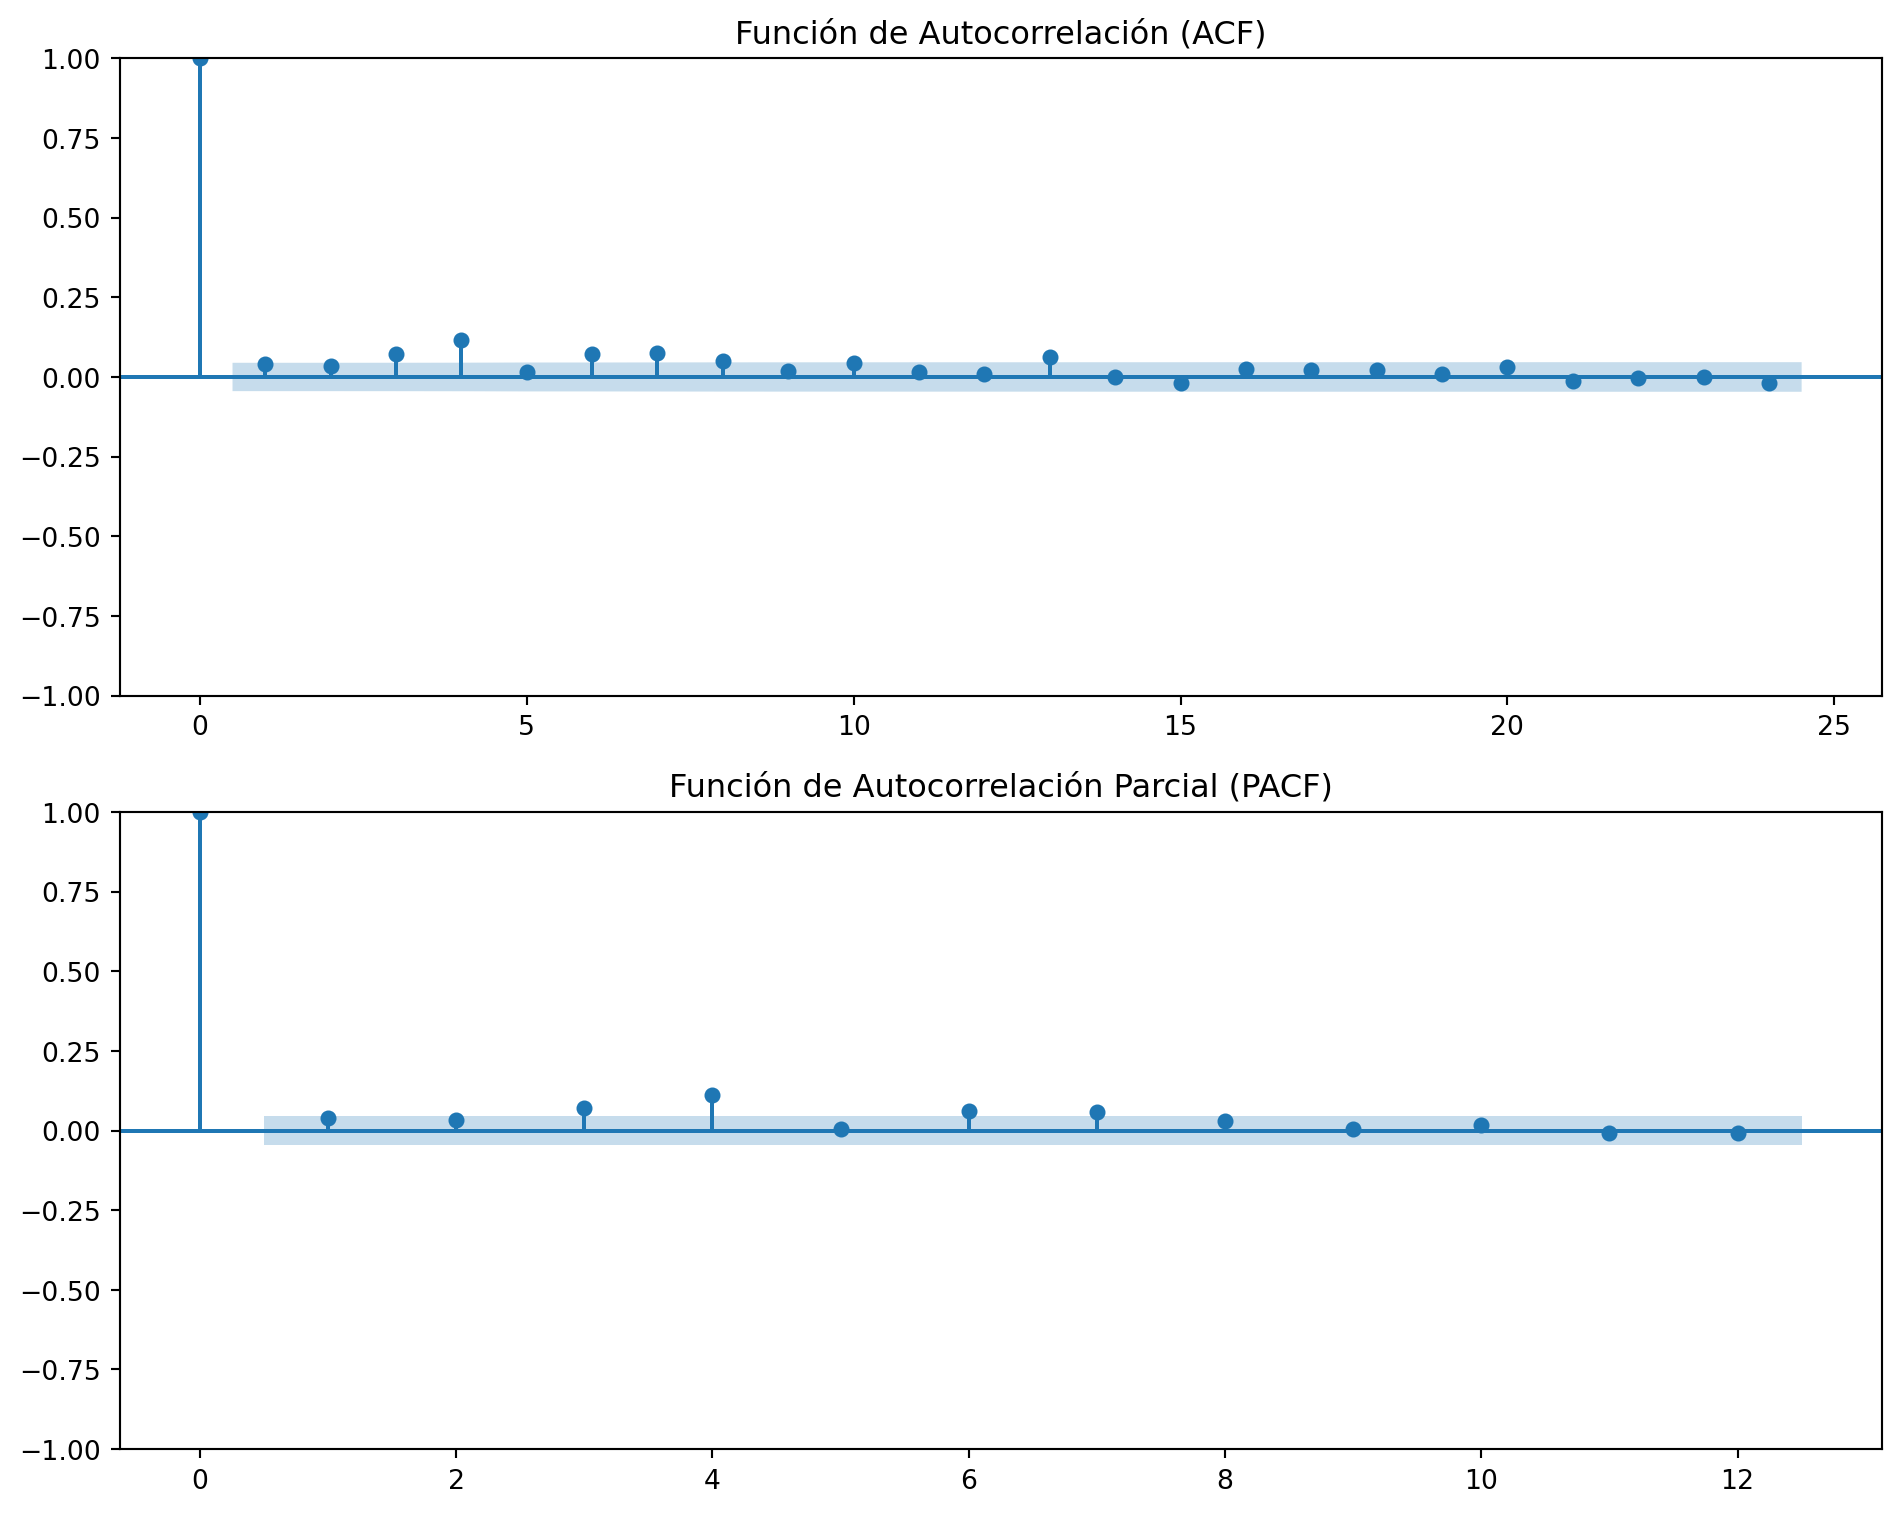

El análisis de autocorrelación nos proporciona más detalles sobre la estructura interna de la serie. El gráfico de la **Función de Autocorrelación (ACF)** muestra un pico significativo en el primer rezago, seguido de valores cercanos a cero para los rezagos posteriores. Este patrón es indicativo de un proceso de media móvil de primer orden (**MA(1)**), donde los choques aleatorios tienen un impacto significativo en el primer rezago pero no en los siguientes. La **Función de Autocorrelación Parcial (PACF)** refuerza esta conclusión, mostrando un comportamiento similar con un pico en el primer rezago y valores prácticamente nulos a partir del segundo rezago. Esto sugiere que un modelo MA(1) sería apropiado para capturar las dinámicas de corto plazo en la serie.

En conjunto, este análisis exploratorio sugiere que la serie de retornos del IRP-GOBIX presenta características complejas, como **volatility clustering**, alta **leptocurtosis**, y una estructura de autocorrelación que se ajusta bien a un modelo MA(1). Estos hallazgos proporcionan una base sólida para la estimación de modelos ARMA-GARCH, los cuales podrán capturar de manera efectiva las dinámicas de volatilidad y retornos en el mercado de deuda pública dominicano.

# Resultados

El presente análisis tiene como objetivo modelar la serie temporal de retornos del índice IRP-GOBIX utilizando inicialmente un modelo ARIMA automático (auto-ARIMA) para determinar si es posible capturar la dinámica de los retornos con un modelo basado únicamente en niveles y diferencias de los datos. Adicionalmente, se evaluará la presencia de problemas estructurales, como la heterocedasticidad, que podrían afectar la consistencia del modelo ARIMA. En caso de que este enfoque no sea adecuado, recurriremos a un modelo Zero-GARCH, un tipo específico de GARCH que asume una media cero para los retornos. Este modelo es particularmente útil en mercados de tasas de interés, donde se ha demostrado que los retornos tienden a cero en el largo plazo debido a la fuerte regresión hacia la media de estas variables.

## Análisis del modelo ARIMA

In [5]:
model_auto = auto_arima(returns)
model_auto.summary()

Warnings: [1] Covariance matrix calculated using the outer product of gradients (complex-step).

El modelo SARIMAX(3, 0, 4) se estimó con el objetivo de capturar la dinámica subyacente de la serie de retornos. Aunque los resultados muestran que algunos de los coeficientes del componente autorregresivo (AR) y del promedio móvil (MA) son estadísticamente significativos (e.g., $AR(3)$ con un coeficiente de $0.7691$, $p < 0.001$ y $MA(2)$ con $p < 0.01$), el desempeño general del modelo presenta ciertas limitaciones. El test de heterocedasticidad muestra un valor de 1.11, lo que indica la presencia de heterocedasticidad en la serie, un problema común en series financieras, donde la varianza de los errores no es constante a lo largo del tiempo.

Además, el estadístico de Jarque-Bera de 4395.18, con una probabilidad de $p = 0.00$, confirma que los residuos no siguen una distribución normal, lo que refuerza la idea de que un modelo basado únicamente en niveles, como el ARIMA, podría no ser suficiente para capturar la volatilidad inherente a los retornos del mercado de deuda pública dominicano. Dado que los modelos ARIMA no están diseñados para abordar adecuadamente la heterocedasticidad, pasamos a estimar un modelo GARCH, que es más apropiado para capturar los cambios en la volatilidad.

## Modelo Zero-GARCH

Para abordar las limitaciones del modelo ARIMA, se estimó un modelo GARCH(1,1) con media cero, siguiendo la estructura propuesta por \[@miah_rahman_2016\], quienes demostrarón que los modelos GARCH(1,1) son altamente efectivos para capturar la volatilidad en los retornos de mercados financieros. La elección de un modelo con media cero se justifica porque en mercados de deuda pública y tasas de interés, los retornos tienden a revertir a la media, y en el largo plazo se espera que los retornos por apreciación de capital converjan a cero. \[@fabozzi_fixed_income\]

In [6]:
ar = arch_model(returns, mean='Zero', vol='GARCH', dist='t')
res = ar.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13422.240578344366
Iteration:      2,   Func. Count:     13,   Neg. LLF: 9134.230609110135
Iteration:      3,   Func. Count:     19,   Neg. LLF: 8666.557319151609
Iteration:      4,   Func. Count:     25,   Neg. LLF: 8791.275490419279
Iteration:      5,   Func. Count:     31,   Neg. LLF: 8082.081172585756
Iteration:      6,   Func. Count:     37,   Neg. LLF: 8739.332058159429
Iteration:      7,   Func. Count:     43,   Neg. LLF: 8658.860183258712
Iteration:      8,   Func. Count:     49,   Neg. LLF: 7638.6451038734085
Iteration:      9,   Func. Count:     55,   Neg. LLF: 7626.627815474433
Iteration:     10,   Func. Count:     60,   Neg. LLF: 7624.619361750198
Iteration:     11,   Func. Count:     65,   Neg. LLF: 7623.76815711753
Iteration:     12,   Func. Count:     70,   Neg. LLF: 7623.223103893486
Iteration:     13,   Func. Count:     75,   Neg. LLF: 7623.048366501091
Iteration:     14,   Func. Count:     80,   Neg. LLF: 7622.9986

In [7]:
res.summary()

Covariance estimator: robust

Los resultados del modelo Zero-GARCH confirman un buen ajuste a la volatilidad de la serie de retornos. El coeficiente $\omega$ del proceso de volatilidad es de $58.8679$ ($p < 0.05$), lo que indica un nivel base significativo de volatilidad en la serie. El parámetro $\alpha_1$, que mide la influencia de los shocks pasados en la volatilidad actual, es positivo y significativo ($0.1892$, $p < 0.01$), lo que sugiere que los shocks pasados tienen un impacto considerable en la volatilidad presente. Por otro lado, $\beta_1$ ($0.7737$, $p < 0.001$) indica que existe una fuerte persistencia en la volatilidad, característica común en los mercados financieros, donde las fases de alta volatilidad tienden a durar varios periodos.

El uso de la distribución t de Student para los residuos estandarizados, con un parámetro $\nu$ de $2.7894$ ($p < 0.001$), confirma la presencia de colas más gruesas en la distribución de los retornos, lo que es consistente con la leptocurtosis observada en la serie de retornos.

### Residuos del Zero-GARCH

``` python
fig = res.plot()
```

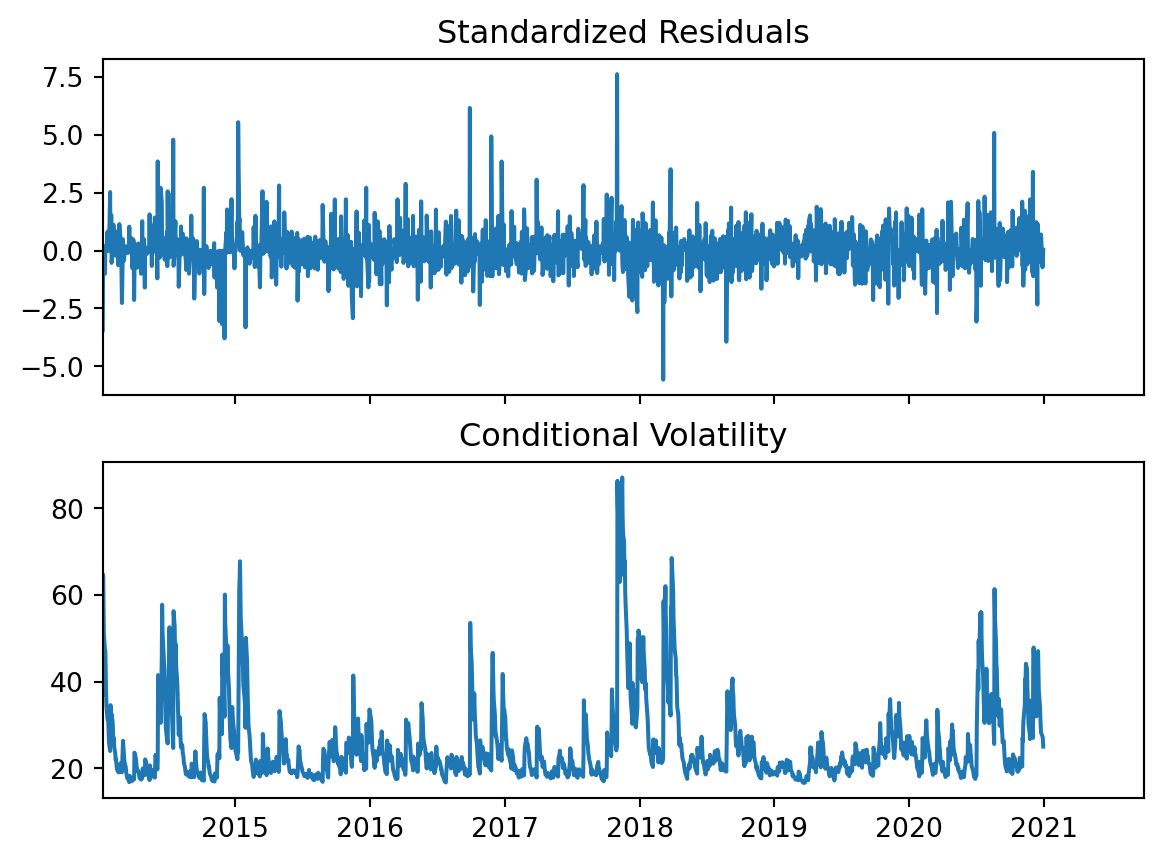

Al analizar los residuos estandarizados y la volatilidad condicional en el modelo Zero-GARCH, observamos cómo la volatilidad responde de manera dinámica a los choques en los retornos. En la primera gráfica, se aprecia que la volatilidad condicional es mayor durante episodios donde los residuos estandarizados alcanzan picos extremos, especialmente en periodos de alta volatilidad como 2018. Esto refuerza la capacidad del modelo GARCH para capturar **volatility clustering**, un fenómeno donde la alta volatilidad tiende a agruparse en ciertos periodos. Además, la persistencia de la volatilidad condicional a lo largo del tiempo confirma que los choques pasados tienen un efecto prolongado, lo cual es coherente con los resultados obtenidos en los coeficientes del modelo GARCH.

### Residuos contra volatilidad condicional

``` python
std_resid = res.resid / res.conditional_volatility
unit_var_resid = res.resid / res.resid.std()
df = pd.concat([std_resid, unit_var_resid], axis=1)
df.columns = ["Residuos Estandarizados", "Residuos de Varianza Unitaria"]
subplot = df.plot(kind="kde", xlim=(-4, 4))
```

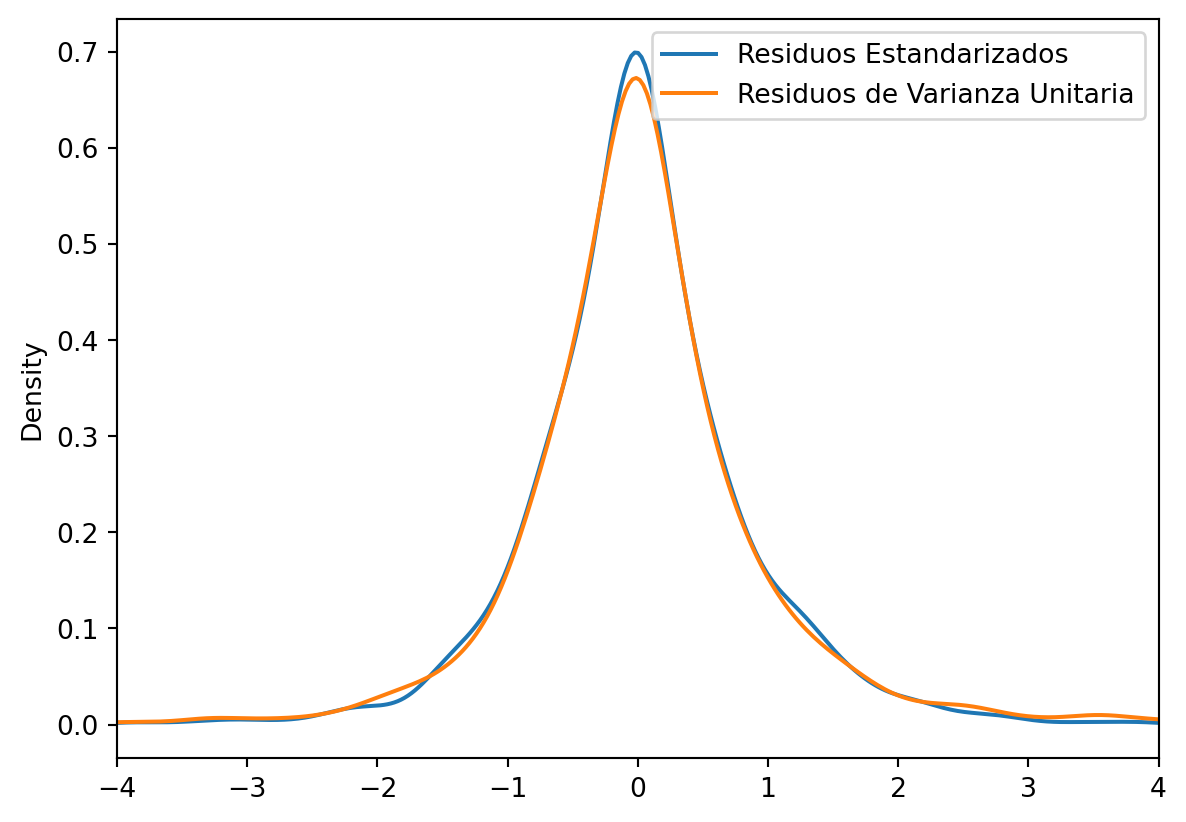

En cuanto a la comparación entre los residuos estandarizados y los residuos de varianza unitaria, la segunda gráfica revela que ambos conjuntos de residuos presentan distribuciones similares, con una alta concentración alrededor de cero. Sin embargo, las colas más gruesas en los residuos estandarizados indican la presencia de eventos extremos más pronunciados, los cuales son típicos en series financieras que presentan leptocurtosis. Esta comparación subraya la importancia de utilizar distribuciones robustas, como la t de Student, para capturar adecuadamente las colas de la distribución, tal como lo hace el modelo GARCH en este caso.

Los resultados del modelo Zero-GARCH confirman su capacidad para modelar de manera efectiva la volatilidad en los retornos del IRP-GOBIX. Aunque el modelo auto-ARIMA capturó algunos patrones de la serie, su inconsistencia en la presencia de heterocedasticidad subraya la necesidad de un enfoque basado en modelos GARCH. El modelo Zero-GARCH no solo demuestra un buen ajuste a los datos, sino que también captura la dinámica de la volatilidad condicional y los residuos estandarizados, revelando la presencia de **volatility clustering** y la persistencia en la volatilidad.

La comparación entre los residuos estandarizados y los residuos de varianza unitaria destaca la capacidad del modelo para manejar eventos extremos, una característica esencial en el análisis de series financieras. En resumen, el modelo Zero-GARCH es más robusto y adecuado para describir las dinámicas de volatilidad en el mercado de deuda pública dominicano, brindando información crucial sobre la persistencia y el comportamiento de la volatilidad a lo largo del tiempo.

## Evaluación Retrospectiva (Backtesting)

Para evaluar la capacidad predictiva del modelo Zero-GARCH, se realizó un análisis de backtesting sobre el periodo comprendido durante el año 2021. Se emplearon dos métodos principales de evaluación: el MAPE (Mean Absolute Percentage Error) y el análisis gráfico de los valores predichos frente a los valores actuales de la desviación estándar móvil.

``` python
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(R_test.index, R_test,
        label='Desviación Estándar Móvil Real', color='blue')
ax.plot(forecasted_std.index,
        forecasted_std, label='Desviación Estándar Móvil Pronosticada', color='red', linestyle='--')
ax.set_xlim([forecasted_std.index.min(), forecasted_std.index.max()])
plt.legend()
plt.show()
```

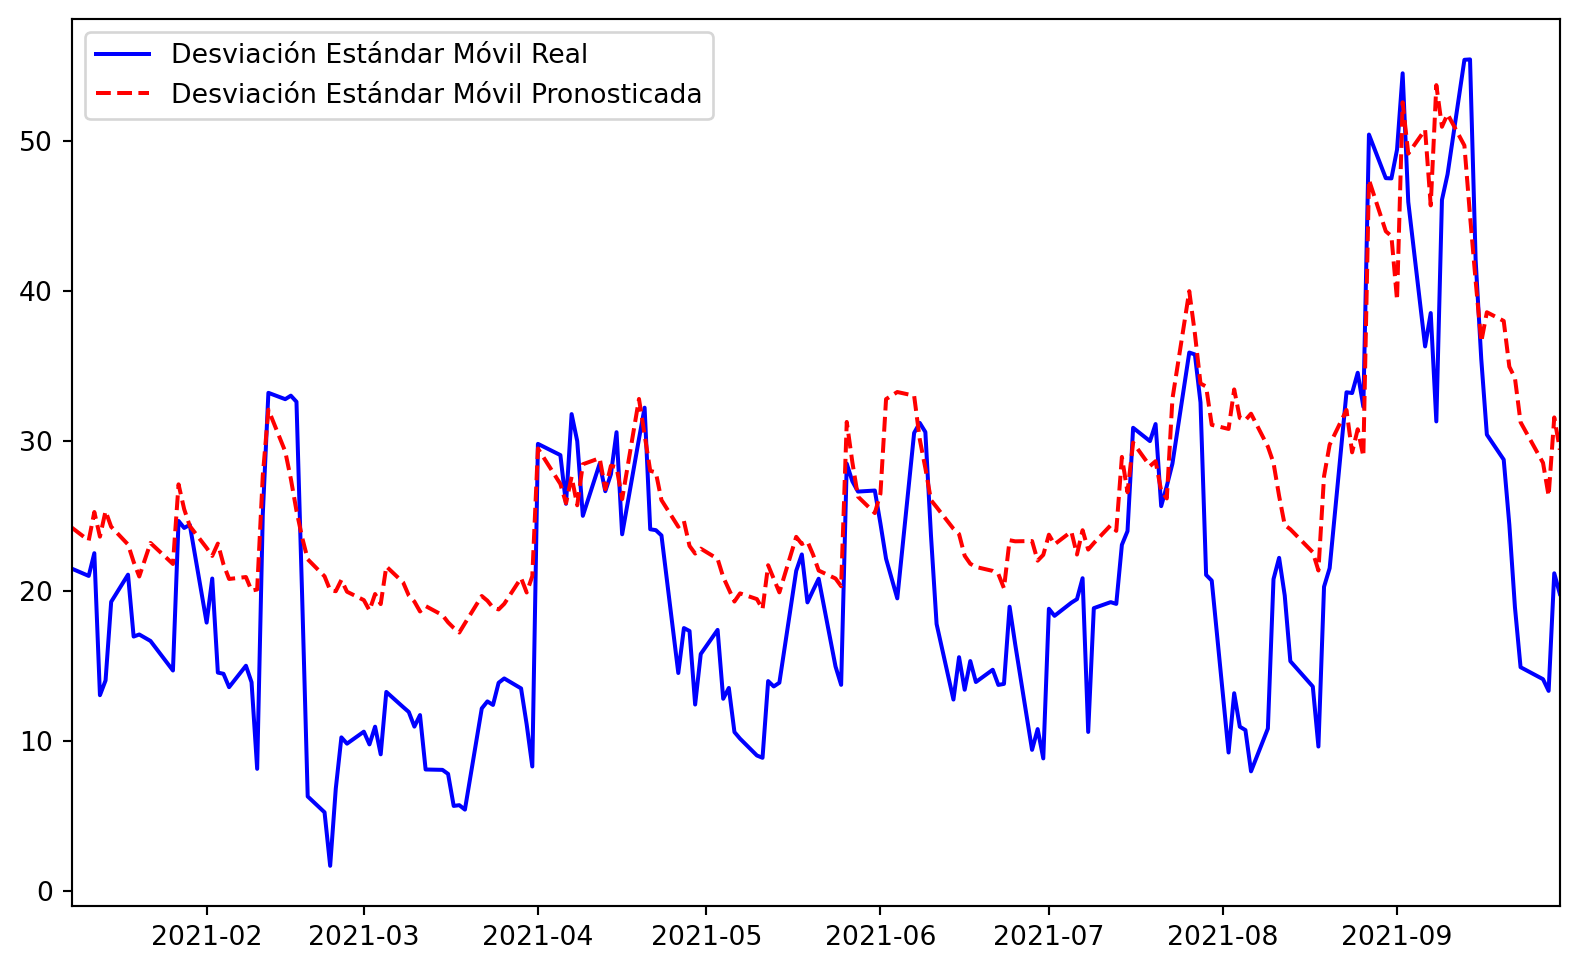

El análisis gráfico (Predichos vs Actuales) revela que el modelo captura de manera excelente la **tendencia** general de la serie, lo que implica que el modelo es eficiente a la hora de predecir los movimientos de largo plazo en la volatilidad. Sin embargo, un problema importante que surge es que el modelo tiende a suavizar los movimientos bruscos, especialmente en momentos donde la volatilidad sufre caídas o picos repentinos. Este fenómeno de **sobre-suavización** implica que el modelo no es completamente reactivo a los choques regresivos de gran magnitud, lo que puede deberse a la estructura propia del GARCH, la cual tiende a modelar la volatilidad alrededor de la media del periodo.

El MAPE calculado para el conjunto de test arroja un valor elevado de **739.70%**, lo cual podría sugerir en un análisis superficial que el modelo no es adecuado. Sin embargo, es importante considerar el tipo de mercado con el que estamos trabajando, caracterizado por una volatilidad intrínsecamente elevada y movimientos extremos. En estos contextos, valores altos de MAPE son comunes debido a la alta variabilidad en los retornos, lo que no necesariamente implica una mala capacidad predictiva, sino que refleja la naturaleza errática de los datos financieros. En este sentido, el MAPE alto está más relacionado con la complejidad del mercado que con la falta de ajuste del modelo.

El backtesting del modelo Zero-GARCH sobre la serie de retornos del IRP-GOBIX para el periodo de 2021 confirma que, si bien el modelo captura correctamente la tendencia general de la volatilidad, su capacidad para reaccionar ante movimientos abruptos es limitada. A pesar de esto, dado el contexto del mercado de deuda pública dominicano, la sobre-suavización en los niveles es un comportamiento esperado en modelos de volatilidad como el GARCH. En resumen, el modelo es útil para predecir tendencias a largo plazo, pero su precisión en niveles podría mejorarse si se ajusta para reaccionar mejor a eventos extremos.

# Discusión y Conclusión

## Discusión

Este estudio ha permitido modelar los retornos y la volatilidad del mercado de deuda pública dominicano utilizando modelos ARIMA-GARCH. A pesar de los hallazgos significativos, existen algunas limitaciones que deben considerarse al interpretar los resultados:

-   **Problemas con la sobre-suavización**: Como se observó en el análisis retrospectivo, el modelo Zero-GARCH tiende a suavizar los movimientos bruscos en la volatilidad, lo que puede limitar su capacidad de capturar adecuadamente choques repentinos en el mercado. Aunque el modelo refleja bien la tendencia general, su capacidad de reacción frente a eventos extremos debe ser mejorada.

-   **MAPE elevado**: El MAPE obtenido durante la evaluación retrospectiva fue considerablemente alto. Si bien esto puede justificarse por la naturaleza volátil del mercado de deuda pública, sugiere que el modelo puede tener problemas para ajustarse a los movimientos de corto plazo. La alta volatilidad y los choques repentinos no fueron capturados con precisión, afectando el rendimiento del modelo.

-   **Limitaciones en los datos**: El análisis se centró en un período específico (2014-2021), excluyendo la pandemia debido a sus características atípicas. Si bien esto ayudó a evitar sesgos, la exclusión de este período crítico puede haber omitido dinámicas importantes del mercado en tiempos de crisis, limitando la generalización de los resultados.

## Conclusión

En conclusión, este estudio ha demostrado que el modelo ARIMA, aunque útil para capturar la estructura de los retornos del mercado de deuda pública dominicano, presenta limitaciones cuando se enfrenta a problemas de heterocedasticidad. El modelo Zero-GARCH, por su parte, ha demostrado ser más adecuado para describir la dinámica de la volatilidad, capturando fenómenos como la persistencia en la volatilidad y el clustering. Además, la capacidad del modelo para manejar eventos extremos a través de la distribución t de Student resulta valiosa en este tipo de mercados caracterizados por alta volatilidad y choques inesperados.

Entre los principales hallazgos destacan:

-   **Volatility clustering**: El análisis confirmó la presencia de agrupación de volatilidad, donde periodos de baja volatilidad son seguidos por periodos de alta volatilidad, un fenómeno común en los mercados financieros.

-   **Persistencia de la volatilidad**: El coeficiente $\beta_1$ significativo en el modelo GARCH sugiere que los shocks en la volatilidad tienen un efecto prolongado en el tiempo, lo que es consistente con los patrones observados en mercados financieros emergentes como el dominicano.

-   **Dificultad para capturar movimientos extremos**: Aunque el modelo Zero-GARCH es efectivo en capturar la tendencia general, su capacidad para reaccionar ante cambios bruscos en la volatilidad sigue siendo limitada, lo cual es un área de mejora para futuras investigaciones.

-   **Implicaciones para los inversores**: Los resultados ofrecen una herramienta útil para la predicción de tendencias de volatilidad a largo plazo en el mercado de deuda pública dominicano, proporcionando una base para la toma de decisiones estratégicas en la gestión del riesgo.

Este estudio no solo contribuye al entendimiento del comportamiento de los retornos y la volatilidad en el mercado de deuda pública dominicano.

# Referencias